### Laboration deep learning AI21
---
Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.
I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

---
0. EDA och filhantering (*)

a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder,
glöm inte att lägga till den till .gitignore.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
import random
import os
import shutil


plt.style.use("seaborn-white")

In [2]:
#train_path = "original_data/train/train/"
train_path="/kaggle/input/dogs-vs-cats/train/train"
test_path="/kaggle/input/dogs-vs-cats/test/test"

files_train_path = os.listdir(train_path)

images_names = pd.DataFrame({"file_name" : files_train_path})
print(f"total number of images: {len(images_names)}")
images_names.head(10)

df_cat = images_names[images_names["file_name"].str.contains("cat")==True]
df_dog = images_names[images_names["file_name"].str.contains("dog")==True]

print(f"number of cats: {len(df_cat)}, number of dogs: {len(df_dog)}")

total number of images: 25000
number of cats: 12500, number of dogs: 12500


In [3]:
df_cat

file_name
0         cat.0.jpg
1         cat.1.jpg
2        cat.10.jpg
3       cat.100.jpg
4      cat.1000.jpg
...             ...
12495  cat.9995.jpg
12496  cat.9996.jpg
12497  cat.9997.jpg
12498  cat.9998.jpg
12499  cat.9999.jpg

[12500 rows x 1 columns]

In [4]:
df_dog

file_name
12500     dog.0.jpg
12501     dog.1.jpg
12502    dog.10.jpg
12503   dog.100.jpg
12504  dog.1000.jpg
...             ...
24995  dog.9995.jpg
24996  dog.9996.jpg
24997  dog.9997.jpg
24998  dog.9998.jpg
24999  dog.9999.jpg

[12500 rows x 1 columns]

b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [5]:
def pick_random_imgs(data_path, n_of_images=10):

    image_names= os.listdir(data_path)
    image_names_picked = random.sample(image_names, n_of_images)
    return image_names_picked

def get_label(data_path, image_names_picked):
    labels=[]
    images=[]

    for image_name in image_names_picked:
        label = image_name.split('.')[0]
        if label == 'cat':
            labels.append(0)
        else:
            labels.append(1)
        img = plt.imread(f"{data_path}{image_name}")
        images.append(img)
    images = np.asarray(images, dtype=object)    
    labels = np.asarray(labels)
    # np.asarray to solve problem: 'list' object has no attribute 'shape'
        
    return images, labels

def plot_imgs(images, labels, ncols = 5, figsize = (20,20), n_of_images=10):
    nrows = int(n_of_images/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)
	
    for i, ax, label in zip(range(n_of_images), axes.flatten(), labels):
        ax.imshow(images[i])
        ax.axis("off")
        if label==0:
            ax.set(title=f'{label}:cat')
        else:
            ax.set(title=f'{label}:dog')

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

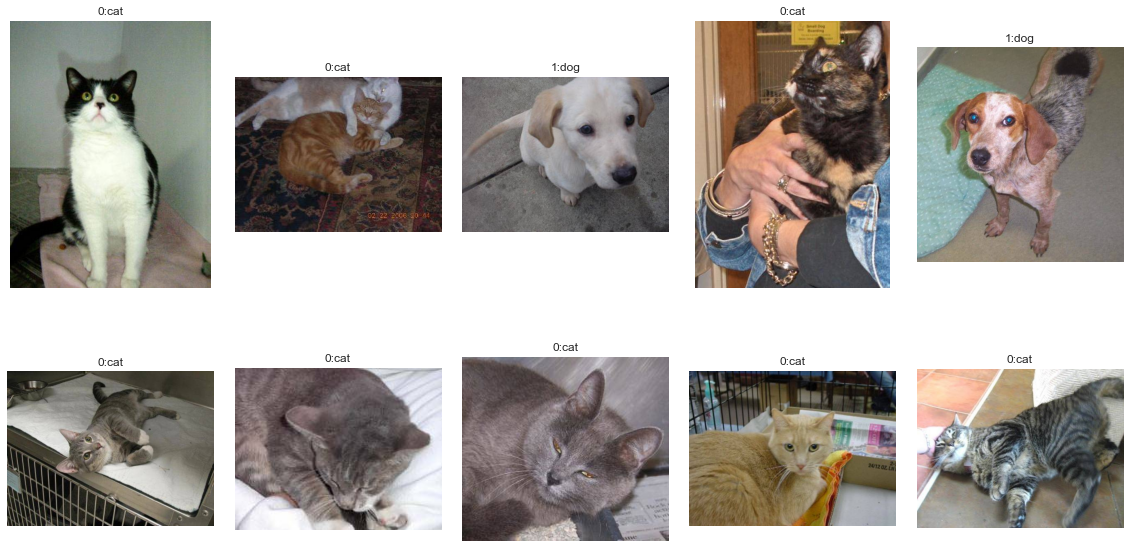

In [6]:
image_names_picked= pick_random_imgs(train_path)
images, labels = get_label(train_path, image_names_picked)
plot_imgs(images, labels)

c) Skapa folderstrukturen nedan med Python, Notera att det är okej att ha fler pythonskript, notebooks, fler experiment, eller annat relevant i labbfoldern. Glöm inte att ha gitignore på datafilerna.

In [7]:
folder_size = ['small', 'tiny']
folder_type = ['train', 'test', 'val']

for size in folder_size:
    try:
        os.mkdir(f"experiment_{size}_data")
        for type in folder_type:
            os.mkdir(f"experiment_{size}_data/{type}")
    except FileExistsError as err:
        shutil.rmtree(f"experiment_{size}_data")
        os.mkdir(f"experiment_{size}_data")
        for type in folder_type:
            os.mkdir(f"experiment_{size}_data/{type}")


d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

In [8]:
from sklearn.model_selection import train_test_split
def split_imgs(df_names, n_train, n_val, n_test):
    df_picked = df_names.sample(n_train+n_val+n_test, random_state=42)
    X_train, X_val_test = train_test_split(df_picked, test_size=n_val+n_test, random_state=42)
    X_val, X_test = train_test_split(X_val_test, test_size=n_test, random_state=42)

    return X_train, X_val, X_test

In [9]:
def save_images(processed_images_path, data):
    for img_name in data:
        source_path = f"{train_path}{img_name}"
        target_path = f"{processed_images_path}{img_name}"
        shutil.copyfile(source_path, target_path)

In [10]:
dfs=[df_cat, df_dog]
for df in dfs:
    X_train, X_val, X_test = split_imgs(df, 800, 200, 250)
    processed_images_path = f'experiment_small_data/train/'
    save_images(processed_images_path, X_train['file_name'])
    processed_images_path =f'experiment_small_data/val/'
    save_images(processed_images_path, X_val['file_name'])
    processed_images_path =f'experiment_small_data/test/'
    save_images(processed_images_path, X_test['file_name'])

In [11]:
dfs=[df_cat, df_dog]
for df in dfs:
    X_train, X_val, X_test = split_imgs(df, 80, 20, 25)
    processed_images_path = f'experiment_tiny_data/train/'
    save_images(processed_images_path, X_train['file_name'])
    processed_images_path =f'experiment_tiny_data/val/'
    save_images(processed_images_path, X_val['file_name'])
    processed_images_path =f'experiment_tiny_data/test/'
    save_images(processed_images_path, X_test['file_name'])

In [12]:
def random_and_get_label(path):
    files = os.listdir(path)
    random.shuffle(files)
    X_train, y_train = get_label(path, files)
    return X_train, y_train

In [13]:
X_train_small, y_train_small = random_and_get_label("experiment_small_data/train/")
X_val_small, y_val_small  = random_and_get_label("experiment_small_data/val/")
X_test_small, y_test_small = random_and_get_label("experiment_small_data/test/")

X_train_tiny, y_train_tiny = random_and_get_label("experiment_tiny_data/train/")
X_val_tiny, y_val_tiny = random_and_get_label("experiment_tiny_data/val/")
X_test_tiny, y_test_tiny = random_and_get_label("experiment_tiny_data/test/")

e) Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara
one-hot encoded med 0 och 1.
- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.


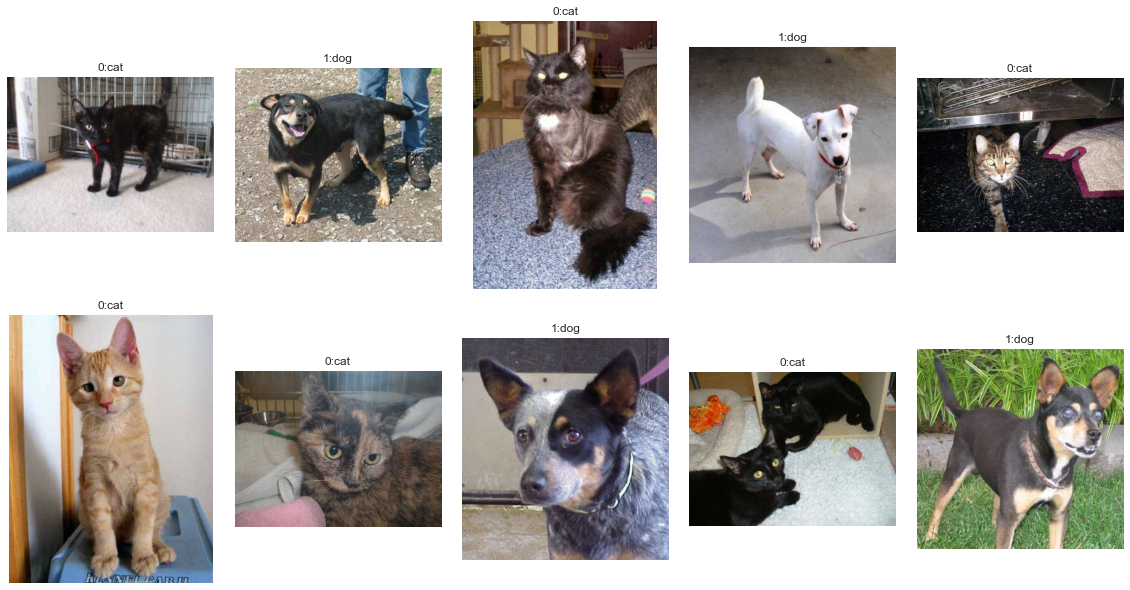

In [14]:
path = 'experiment_small_data/train/'
image_names_picked= pick_random_imgs(path)
images, labels = get_label(train_path, image_names_picked)
plot_imgs(images, labels)

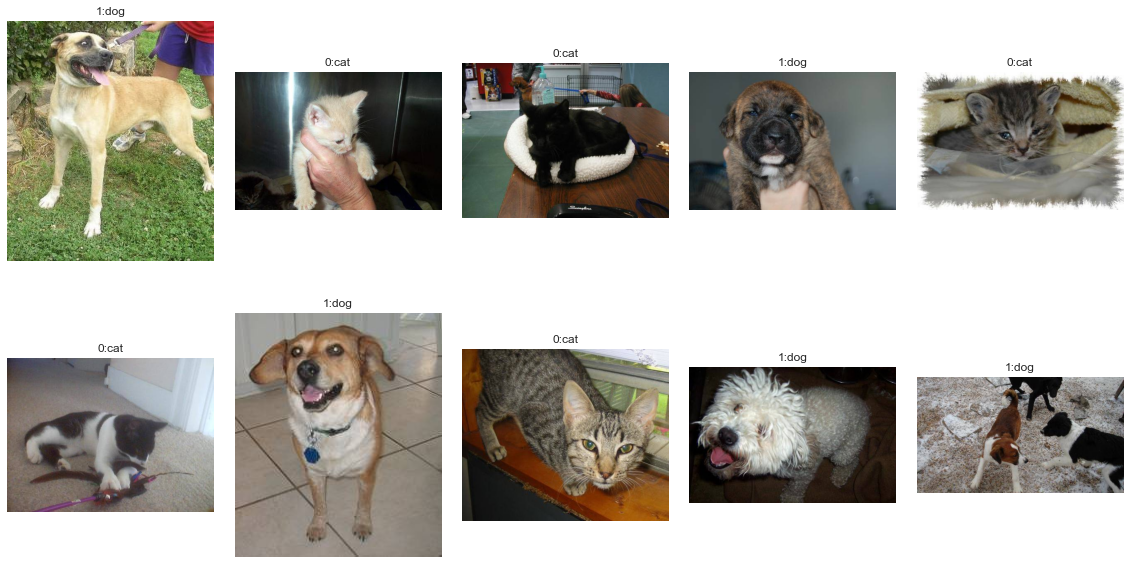

In [15]:
path = 'experiment_tiny_data/train/'
image_names_picked= pick_random_imgs(path)
images, labels = get_label(train_path, image_names_picked)
plot_imgs(images, labels)

In [16]:
X_train_small.shape, y_train_small.shape, X_val_small.shape, y_val_small.shape, X_test_small.shape, y_test_small.shape

((1600,), (1600,), (400,), (400,), (500,), (500,))

In [17]:
X_train_tiny.shape, y_train_tiny.shape, X_val_tiny.shape, y_val_tiny.shape, X_test_tiny.shape, y_test_tiny.shape

((160,), (160,), (40,), (40,), (50,), (50,))

In [18]:
X_train_tiny

array([array([[[ 26,  23,   4],
               [ 26,  23,   4],
               [ 26,  23,   4],
               ...,
               [  0,  13,  16],
               [  0,  13,  16],
               [  0,  13,  16]],

              [[ 26,  23,   4],
               [ 26,  23,   4],
               [ 26,  23,   4],
               ...,
               [  0,  13,  16],
               [  0,  13,  16],
               [  0,  13,  16]],

              [[ 25,  22,   3],
               [ 25,  22,   3],
               [ 26,  23,   4],
               ...,
               [  0,  14,  17],
               [  0,  14,  17],
               [  0,  14,  17]],

              ...,

              [[ 84, 102, 112],
               [ 83, 101, 111],
               [ 82, 100, 110],
               ...,
               [ 99, 125, 138],
               [ 99, 126, 137],
               [ 99, 126, 137]],

              [[ 86, 104, 114],
               [ 86, 104, 114],
               [ 86, 104, 114],
               ...,
        

In [19]:
y_train_tiny

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1])

- skapa lämplig plot för att kontrollera att dataseten är balanserade


In [20]:
data = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
dataset_name = ["Small Dataset train", "Small Dataset val", "Small Dataset test", "Tiny Dataset train", "Tiny Dataset val", "Tiny Dataset test"]

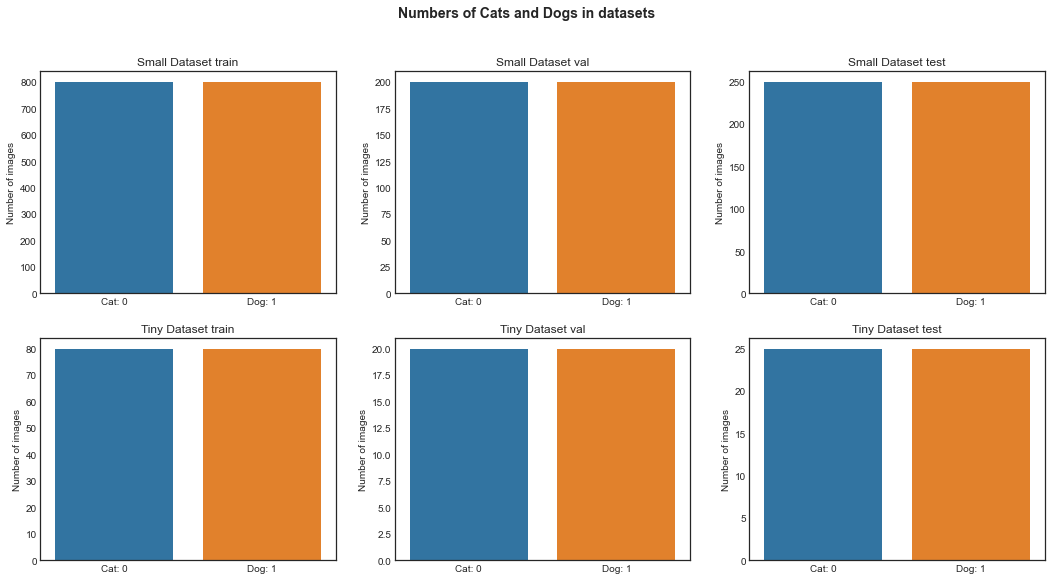

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.countplot(x=dataset, ax=ax)
    ax.set(title=name, ylabel="Number of images")
    ax.set_xticklabels(["Cat: 0", "Dog: 1"], size=10)

fig.suptitle("Numbers of Cats and Dogs in datasets", size=14, fontweight="bold");

- skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

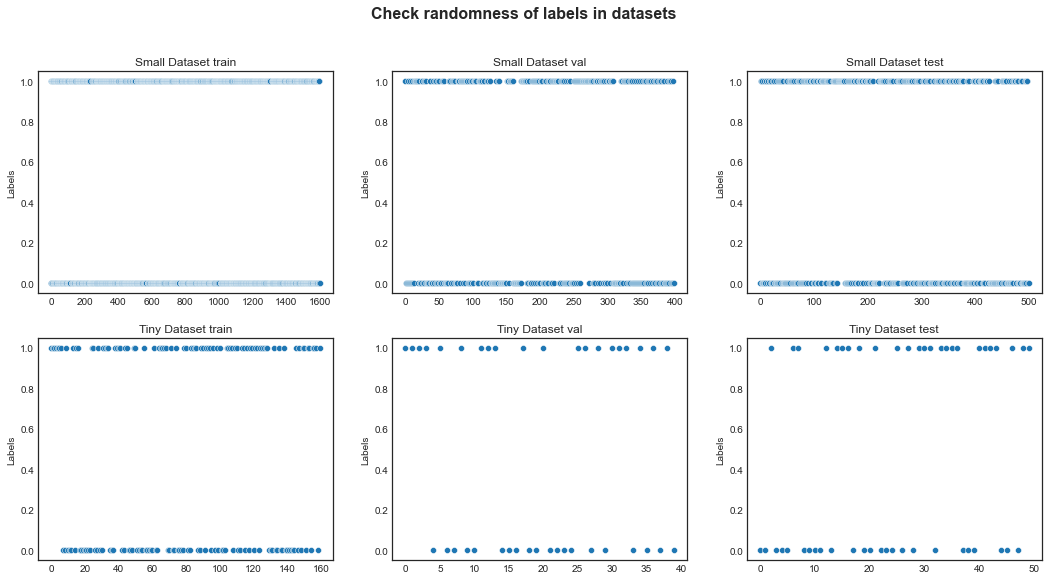

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.scatterplot(data=dataset, ax=ax)
    ax.set(title=name, ylabel="Labels")
    ax.yticklabels=[0,1]

fig.suptitle("Check randomness of labels in datasets", size=16, fontweight="bold");

### 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

- a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

In [23]:
def plot_img_size(train_dir, train_name):
    heights = []
    widths = []
    imagefiles=[os.path.join(train_dir,f) for f in os.listdir(train_dir)]
    for image in imagefiles:
        img = plt.imread(image)
        #print(f"Original shape {img.shape}")
        height = img.shape[0]
        width = img.shape[1]
        heights.append(height)
        widths.append(width)

    figure = sns.jointplot(x=widths, y=heights)
    figure.ax_joint.set_xlabel('width')
    figure.ax_joint.set_ylabel('height')
    figure.fig.suptitle(f"Image size: {train_name}", size=12, fontweight='bold');

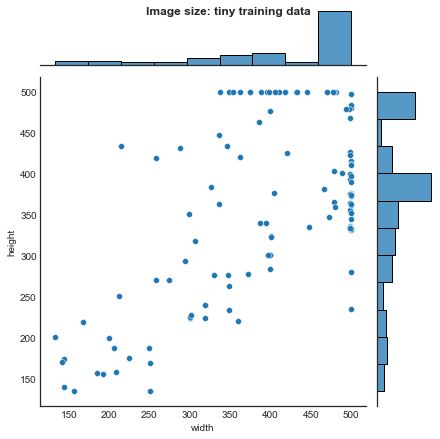

In [24]:
plot_img_size("experiment_tiny_data/train/", "tiny training data")

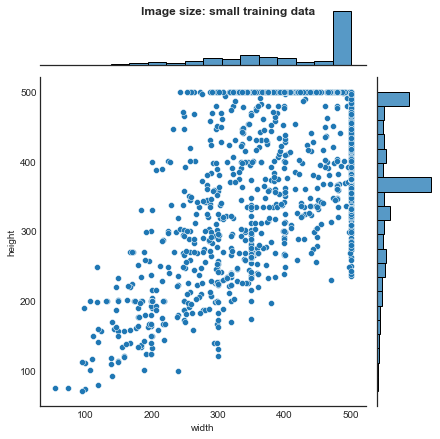

In [25]:
plot_img_size("experiment_small_data/train/", "small training data")

- b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?

In [60]:
IMG_SIZE = 256

- c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:
Visualisera därefter ett par styckena bilder.

In [61]:
def resize_images(data):
    data_resized = [cv2.resize(data[i], (IMG_SIZE, IMG_SIZE)) for i in range(len(data))]
    data_resized = np.asarray(data_resized)
    return data_resized

In [62]:
X_train_small_resized = resize_images(X_train_small)
X_val_small_resized = resize_images(X_val_small)
X_test_small_resized = resize_images(X_test_small)
X_train_tiny_resized = resize_images(X_train_tiny)
X_val_tiny_resized = resize_images(X_val_tiny)
X_test_tiny_resized = resize_images(X_test_tiny)


In [39]:
print(X_train_small_resized.shape, X_val_small_resized.shape, X_test_small_resized.shape, X_train_tiny_resized.shape, X_val_tiny_resized.shape, X_test_tiny_resized.shape)

(1600, 256, 256, 3) (400, 256, 256, 3) (500, 256, 256, 3) (160, 256, 256, 3) (40, 256, 256, 3) (50, 256, 256, 3)


In [52]:
print(y_train_small.shape, y_val_small.shape, y_test_small.shape, y_train_tiny.shape, y_val_tiny.shape, y_test_tiny.shape)

(1600,) (400,) (500,) (160,) (40,) (50,)


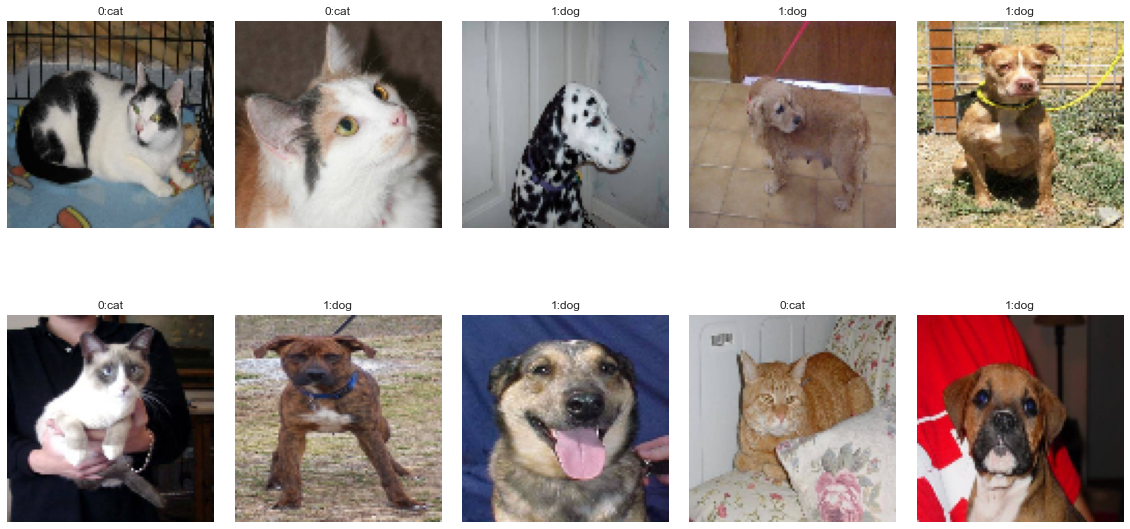

In [30]:
plot_imgs(X_train_small_resized, y_train_small)

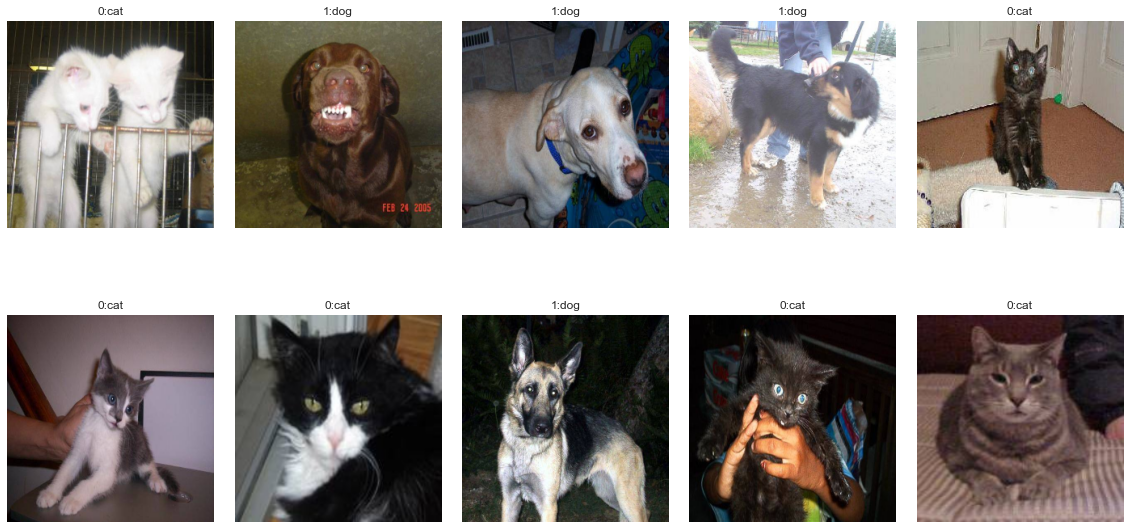

In [40]:
plot_imgs(X_test_small_resized, y_test_small)

d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar vilka parametrar du valt för augmenteringen?


The movitation to use Data augmentation is to increase the amount of data. The techniques are: slightly modifing copies of already existing data, newly creating synthetic data from existing data etc. It acts as a regularizer. The benefit of data augmentation is to reduce overfitting prolem when training a machine learning model. 

In [41]:
X_train_small_resized.min()

0

In [54]:
print(f"min: {X_train_small_resized.min()}, max: {X_train_small_resized.max()}")
scaled_X_train_small_resized = X_train_small_resized.astype("float32") / 255
scaled_X_val_small_resized = X_val_small_resized.astype("float32") / 255
print(f"scaled min: {scaled_X_train_small_resized.min()}, scaled max: {scaled_X_train_small_resized.max()}")

min: 0, max: 255
scaled min: 0.0, scaled max: 1.0


train data: X_train_val; scaled_X_train_small_resized
val data: X_val; scaled_X_val_small_resized
test data: X_test; X_test

In [55]:
scaled_X_train_small_resized.shape, scaled_X_val_small_resized.shape, y_train_small.shape, y_val_small.shape

((1600, 256, 256, 3), (400, 256, 256, 3), (1600,), (400,))

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator_augmentation(scaled_X_train_resized, y_train, scaled_X_val_resized, y_val):
    train_image_generator = ImageDataGenerator(
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        height_shift_range=0.2,
        width_shift_range=0.2,
    )

    # don't augment test data and validation data as we want to test on original data
    # we just instantiate an ImageDataGenerator without augmentation
    test_image_generator = ImageDataGenerator()


    # batch size 32 for mini-batch gradient descent 
    train_generator = train_image_generator.flow(
        scaled_X_train_resized, y_train, batch_size=32
    )
    # mini-batch gradient descent to get uncorrelated 
    # batch size 32 for mini-batch gradient descent 


    val_generator = test_image_generator.flow(scaled_X_val_resized, y_val, batch_size=32)

    # NumpyArrayIterator
    return train_generator, val_generator

In [57]:
train_augmentation_small, val_augmentation_small = image_generator_augmentation(scaled_X_train_small_resized, y_train_small, scaled_X_val_small_resized, y_val_small)
#train_augmentation_tiny, val_augmentation_tiny = image_generator_augmentation(scaled_X_train_tiny_resized, y_train_tiny, scaled_X_val_tiny_resized, y_val_tiny)

### 2. Träna modeller (*)
För uppgifterna nedan, jobba med dataseten en åt gången:

small:
- utan augmentering
- med augmentering

tiny (BONUS):
- utan augmentering
- med augmentering

a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.3, kernels=[32, 64, 128, 128]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy", optimizer=adam, metrics=["acc"]
    )
 

    return model

model = CNN_model()

model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0 